In [1]:
#math and linear algebra stuff
import numpy as np
import numpy.linalg as la

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Solving least absolute deviation with positivity constraint using Chambolle Pock

## Introduction

This notebook has been designed after reading an article from Camille Sutour about noise estimation in images (Noise level function).
In this work, she tries to estimate the NLF (noise level function) with a 2 order polynomial, with non-negative coefficient, hence the positivity constraint.

In order to make the estimator more robust to outliers, she uses as least absolute deviation instead of the classical least square.

#### The usecase: Noise model estimation

After a specific routine has been used, we assume that pure noise patches have been found in an image.

One can assume locally stationary noise behaviour, can then compute for each patch its mean $\mu=\frac{1}{N} \sum_{i=0}^{N-1} x_i$ and the unbiased estimator of variance $\sigma^2=\frac{1}{N-1} \sum_{i=0}^{N-1} (x_i-\mu)^2$.

Given a list of pairs $\left( \hat{\mu_p}, \hat{\sigma_p}^2 \right)$, one is now interested in knowing the Noise Level Function (NLF), which is a $\mathbb{R} \rightarrow \mathbb{R}^+$ function, that gives the noise variance for a fiven level of image intensity.

The author assumes that the NLF is a positively increasing second order polynomial of the image intensity. Then one just performs a least square on the following problem:

\begin{align*}
  \underset{x\in\mathbb{R}^3}{\text{min}} \qquad ||Ax-b||_2^2
\end{align*}

Where we have:

* $A=\begin{pmatrix} 1 & \mu_0 & \mu_0^2\\
1 & \mu_1 & \mu_1^2\\
\vdots & \vdots & \vdots\\
1 & \mu_{N-1} & \mu_{N-1}^2\end{pmatrix}$

* $b=\begin{pmatrix}\sigma_0^2\\ \sigma_1^2 \\ \vdots \\ \sigma_{N-1}^2\end{pmatrix}$

The solution vector $\hat{x}$ is given by Moore-Penrose pseudo-inverse: $A^+ b$ where $A^+=(A^T A)^{-1} A^T$
However, the author prefers to use the least absolute deviation, with positivity constraint:

\begin{align*}
  \underset{x\in\mathbb{R}^{+3}}{\text{min}} \qquad ||Ax-b||_1
\end{align*}

## Studying the problem under the CP framework

### First overview of CP mapping
First of all, one can notice that the constrained optimization problem can be recasted as a non explicitly constrained optimization problem, just by adding a term featuring the convex indicator function of the non-negative orthant in $\mathbb{R}^3$:

\begin{align*}
  \delta_{\mathbb{R}^{3+}}(x) &= 
    \begin{cases}0 \qquad &\text{if } x \in \mathbb{R}^{3+} \\
    +\infty & \text{otherwise} \end{cases}
\end{align*}

Such that we can write the new optimization problem:

\begin{align*}
  \underset{x}{\text{min}} \quad ||Ax-b||_1 + \delta_{\mathbb{R}^{3+}}(x)
\end{align*}

We can now try to map this problem to the Chambolle pock pattern:

\begin{align*}
  \underset{x}{min} \quad g(Lx) + f(x)
\end{align*}

where $g=|| \cdot -b||_1$ and $f = \delta_{\mathbb{R}^{3+}}$ are convex functions, whose proximity operators can be computed, and $L=A$ is a linear operator.

and its dual problem:

\begin{align*}
  \underset{u}{min} \quad f^*(-L^*u) + g^*(u)
\end{align*}

### Recalling principle of CP algorithm

The Chambolle-Pock algorithm takes initial estimates $x^{(0)}$ and $u^{(0)}$ of the primal and dual solutions, a parameter $\tau>0$, a second parameter $\sigma>0$ such that $\sigma \tau \|L\|^2 < 1$, and a relaxation parameter $0<\rho<2$, and iterates, for $k=1,2,\ldots$:
  
\begin{align*}
    u^{k} &= \mathrm{prox}_{\sigma g^*}( u^{k-1} + \sigma L \tilde{x}^{k-1}) \\
    x^{k} &= \mathrm{prox}_{\tau f}(  x^{k-1}-\tau L^* u^{k} ) \\
    \tilde{x}^{k} &= x^{k} + \rho (x^{k}-x^{k-1})\\
\end{align*}
  
Where, $x^{(k)}$ converges to a primal solution $x^\star$ and $u^{(k)}$ converges to a dual solution $u^\star$.

### Studying the $g$ part

In our analysis, we set $g(x) = ||x-b||_1$, lets take a look at the convex conjugate of $g$:

#### Derivation of $g^*$

We recall that the definition of $g^*$, the convex conjugate of $g$ is the following:

\begin{align*}
    h^*(u) &= \underset{z}{max} \quad \langle u, z \rangle_{\mathbb{R}^n} - g(z) \\
\end{align*}

In our case, we have:

\begin{align*}
    g^*(u) &= \underset{z}{max} \quad \langle u, z \rangle_{\mathbb{R}^n} -||z-b||_1 \\
    &= \underset{z'}{max} \quad \langle u, z'+b \rangle_{\mathbb{R}^n} -||z'||_1 \qquad \text{with z'=z-b} \\
    &= \underset{z'}{max} \quad \langle u, z' \rangle_{\mathbb{R}^n} + \langle u, b \rangle_{\mathbb{R}^n} -||z'||_1\\
    &= \langle u, b \rangle_{\mathbb{R}^n} + \underbrace{\underset{z'}{max} \quad \langle u, z' \rangle_{\mathbb{R}^n} -||z'||_1}_{||u||_1^{*}}
\end{align*}

We see that convex conjugate of $g$ uses the convex conjugate of $l_1$ norm.

##### Convex conjugate of $l_1$ norm

Computing the convex conjugate of the $l_1$ norm is quite straightforward:

We recall that, for any homogeneous function $f$ (which is such that $f(\alpha x)=\alpha^k f(x) \forall \alpha \in \mathbb{R}$), we can write the convex conjugate as

\begin{align*}
     f^*(u) &= \underset{z \in \mathbb{R}^n \;, \alpha \in \mathbb{R}^+}{max} \quad \langle u, \alpha z \rangle_{\mathbb{R}^n} - f(\alpha z) \qquad , \forall \alpha \in \mathbb{R^+}\\
     &= \underset{z \in \mathbb{R}^n \;, \alpha \in \mathbb{R}^+}{max} \quad \alpha \left( \langle u, z \rangle_{\mathbb{R}^n} - f(z) \right)
\end{align*}

Now, as soon as we have a $z \in \mathbb{R}^n$ such that $\langle u, z \rangle_{\mathbb{R}^n} - f(z)>0$, then one can choose an arbitrarily large $\alpha$, hence making the supremum infinite.
It is easy to see that for every $u$ such that $u_i=| \|u\|_{\infty}| > 1$, we can choose $z_i=sign(u_i)$, and $z_j=0, \; i \neq j$, such that $\sum_{i=0}^{n-1} u_i z_i - \sum_{i=0}^{n-1} |z_i| = |u_i|-1 > 0$

We can apply the same reasonning for the case where $| \|u\|_{\infty}| \le 1$, and show than the conjugate in this case is zero valued. The definition is then related to the $\infty$-ball indicator:

\begin{align*}
  l_1^*(x) &= \chi_{\|\cdot\|_{\infty} \le 1}(x) \\
  &= \begin{cases} 0 \qquad & \text{if } \|x\|_{\infty} \le 1\\ +\infty & \text{otherwise} \end{cases}
\end{align*}

#### Derivation of $g^*$

We can then conclude on $g^*$:

\begin{align*}
    g^*(u) &= \langle u, b \rangle_{\mathbb{R}^n} + ||u||_1^{*} \\
    &= \langle u, b \rangle_{\mathbb{R}^n} + \chi_{\|\cdot\|_{\infty} \le 1}(u) \\
\end{align*}

#### Proximity operator

We recall the definition of proximity operator for a function $h$ reads:

\begin{equation}
    prox_{\gamma h}(u) = \underset{z}{argmin} \quad \frac{1}{2\gamma} \|z-u\|_2^2 + h(z)
\end{equation}

We recall that being able to compute the proximity operator of $f^*$ is equivalent to being able to compute the proximity operator of $f$, thanks to the Moreau identity:
  
\begin{equation}
    x = \mathrm{prox}_{\gamma f^*}(x) + \gamma \mathrm{prox}_{\frac{f}{\gamma}}\left(\frac{x}{\gamma}\right)
\end{equation}

However, in the following notebook, we won't use this property, and derive the proximity operator of $g^*$ directly

#### Proximity operator of $g^*$

We can now write the proximity operator for $g^*$:

\begin{equation}
    prox_{\gamma h}(u) = \underset{z}{argmin} \quad \underbrace{\frac{1}{2\gamma} \|z-u\|_2^2 + \langle z, b \rangle_{\mathbb{R}^n}}_\text{First part} + \underbrace{\chi_{\|\cdot\|_{\infty} \le 1}(z)}_\text{Second part} \\
\end{equation}

If we study the first part of this optimization problem, we have:

\begin{align*}
  & \frac{1}{2\gamma} \|z-u\|_2^2 + \langle z, b \rangle_{\mathbb{R}^n} \\
  =& \frac{1}{2\gamma}  \left( z^t z + u^t u -2 z^t u \right) + z^t b \\
  =& \frac{1}{2\gamma}  \left( z^t z + u^t u -2 z^t \left( u -\gamma b \right) \right) \\
\end{align*}

One can now easily factorize the expression, and put the constant term aside:

\begin{align*}
  =& \frac{1}{2\gamma} \left( \|z-(u-\gamma b)\|_2^2 - \left( \gamma^2 b^t b - 2 \gamma u^t b \right) \right) \\
\end{align*}

We can retain that the mnimization of this expression over $z$ does not depend on the constant term, so that we can rewrite the proximal operator as:

\begin{equation}
    prox_{\gamma h}(u) = \underset{z}{argmin} \quad \frac{1}{2\gamma} \|z-(u-\gamma b)\|_2^2 + \chi_{\|\cdot\|_{\infty} \le 1}(z) \\
\end{equation}

For which a closed form solution could be found : 
\begin{align*}
  prox_{\gamma g^*}(u) &= \Pi_{\|\cdot\|_{\infty}<1} (u-\gamma b)
\end{align*}

Which is the projection of $(u-\gamma b)$ onto the $l_{\infty}$ unit ball.

### Studying the $f$ part

We recall that $f(x)=\delta_{\mathbb{R}^{3+}}$

We also recall that the proximal operator for the convex indicator $\delta_{\mathbb{R}^{3+}}$ is simply the projection operator onto the non-negative orthant $\mathbb{R}^{3+}$:

\begin{align*}
  \text{prox}_{\delta_{\mathbb{R}^{3+}}}(x) &= \Pi_{\mathbb{R}^{3+}}(x)\\
  &= \bar{x} \qquad , \text{s.t} \; \bar{x}_i = \max( 0, x_i) \forall i \in \{0,1,2\}
\end{align*}


## Wrapping up : Chambolle-Pock instance

We now have everything we need for the Chambolle-Pock instance:

The algorithm will start by taking initial estimates $x^{(0)}$ and $u^{(0)}$ of the primal and dual solutions, a parameter $\tau>0$, a second parameter $\sigma>0$ such that $\sigma \tau \|L\|^2 < 1$, and a relaxation parameter $0<\rho<2$, and iterates, for $k=1,2,\ldots$:
  
\begin{align*}
    u^{k} &= \Pi_{\|\cdot\|_{\infty}<1}\left( u^{k-1} + \sigma \left( A\tilde{x}^{k-1} - b\right) \right) \\
    x^{k} &= \Pi_{\mathbb{R}^{3+}}( x^{k-1}-\tau A^t u^{k} ) \\
    \tilde{x}^{k} &= x^{k} + \rho (x^{k}-x^{k-1})\\
\end{align*}

In [19]:
# Numerical application

#First define data: a set of k constant patches of size p*p with different intensities, onto which we applied both
# poisson noise () and additive gaussian noise

#Data size and noise parameters
k=200 # number of patches
p=32  # size of patches
maxBaseDynamic=100
stdGauss=maxBaseDynamic*0.01

# define patch values, and replicate them p*p along the first dimension (of index 0)
patches=np.repeat(np.random.rand(p,p)*maxBaseDynamic, k).reshape(p*p,k) 
#Apply poisson noise, variance is linearly dependant with pixel values (coefficient is 1)
patches=np.random.poisson(patches)
#Add gaussian noise with constant variance equal to stdGauss^2
patches=patches+np.random.normal(0,stdGauss,patches.shape)
print("patches shape is {}".format(patches.shape))

patches shape is (1024, 200)


In [20]:
#Then determine the variance vector b
b=np.var(patches,axis=1)

#And the matrix of the mean polynomial A
maxDegreePolynomial=1
mean=np.mean(patches,axis=1)
A=np.zeros((mean.size,maxDegreePolynomial+1))
for i in range(maxDegreePolynomial+1):
    A[:,i]=np.power(mean,i)
    
# Define the "expected" solution vector
if maxDegreePolynomial==1:
  xhat=np.array([stdGauss**2, 1])
elif maxDegreePolynomial==2:
  xhat=np.array([stdGauss**2, 1, 0])

size is (204800,) and (1024, 200)


No handles with labels found to put in legend.


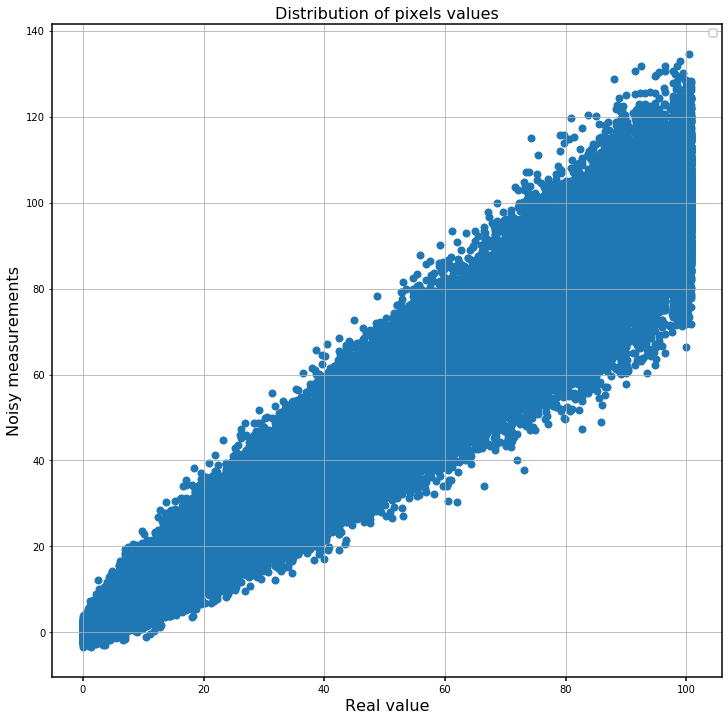

In [21]:
fig, ax = plt.subplots(1,figsize=(12,12))
#for hist_bin in range(nb_bins):
#    mask = (signal_reel>=bin_edges[hist_bin])*(signal_reel<bin_edges[hist_bin+1])
#    c = ax[0].scatter(signal_reel[mask], signal_bruite[mask])
#    ax[0].bar(bins_center[hist_bin], np.mean(signal_bruite[mask]), width=bin_edges[hist_bin+1]-bin_edges[hist_bin],
#              yerr=stds[hist_bin], align='center', alpha=0.5, ecolor='black', capsize=10, color=c.get_facecolors()[0].tolist()
#)
# Bar of the whole dataset
xref = np.repeat(mean, k)
print("size is {} and {}".format(xref.shape, patches.shape))
ax.scatter(xref.flatten(), patches.flatten())
ax.set_title('Distribution of pixels values')
ax.set_xlabel('Real value')
ax.set_ylabel('Noisy measurements')
ax.grid()
ax.legend()


In [34]:
# define the proximity operator that we need:
def prox_g_conj(u, gamma):
  tmp = u-gamma*b
  return np.sign(tmp)*np.minimum(np.abs(tmp),1)
    
def prox_f(x):
  return np.maximum(x,0)

In [35]:
#Run Chambolle-Pock algorithm

Anorm = 1.01*np.linalg.norm(A)**2 #take 10% margin
tau = 1./Anorm
sigma = 1./Anorm
rho = 2 #rho > 1 allows to speed up through momentum effect
nbIter = 100000

xk = np.zeros_like(xhat)  #primal var at current iteration
xk_m1 = np.zeros_like(xhat)
xk_tilde = np.zeros_like(xk)  #primal var estimator
uk = np.zeros_like(A.shape[0]) #dual var
primObj = np.zeros(nbIter)
#dualObj = np.zeros(nbIter)
for iter in range(nbIter):
  uk = prox_g_conj(uk + sigma * np.dot(A,xk_tilde), sigma)
  xk = prox_f( xk_m1 - tau * np.dot(A.T,uk) )
  xk_tilde = xk + rho*( xk - xk_m1 )
  primObj[iter] = np.sum(np.abs(np.dot(A,xk)-b))
  #dualObj[iter] = np.abs(np.dot(A,xk)-b).sum()
  xk_m1 = xk

Got solution [2.33163546 0.97729469] expected value was [2.25 1.  ]


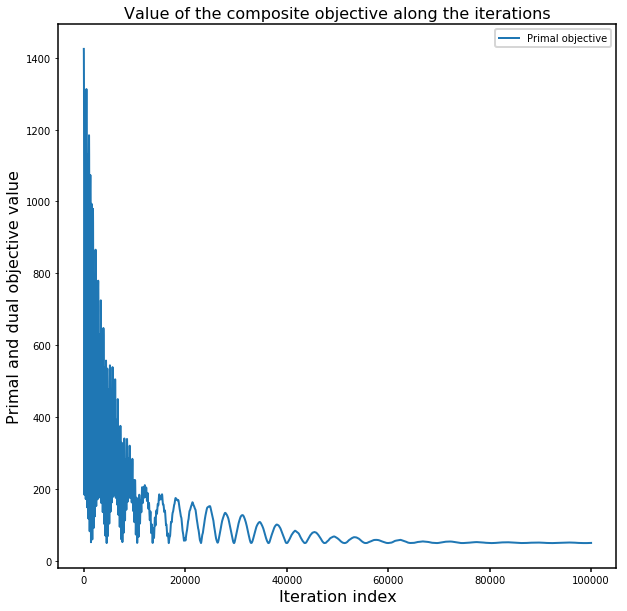

In [37]:
print("Got solution "+str(xk)+" expected value was "+str(xhat))

# Plot/print some informations
plt.figure(1,figsize=(10,10))
plt.title("Value of the composite objective along the iterations")
plt.xlabel("Iteration index")
plt.ylabel("Primal and dual objective value")
plt.plot(range(nbIter),(primObj),label="Primal objective")
#plt.plot(range(nbIter),np.log10(dualObj,out=np.zeros_like(dualObj), where=(dualObj<=0)),label="Dual objective")
plt.legend()
plt.show()

#plt.figure(5,figsize=(10,10))
#plt.xlabel("Iteration index")
#plt.ylabel("Primal-dual gap (logscale)")
#plt.plot(range(nbIter),np.log10(np.abs(primObj-dualObj)))
#plt.title("Primal-dual gap along the iterations")